# Conway's Game of Life

v 1.61 29 January 2018, by Brian Fiedler

[Conway's Game of Life](http://www.bitstorm.org/gameoflife/) is related to simulation of weather. Both are about the change of a variable, or variables, defined on a grid.  The change is determined by the current state of the variable at a grid point and the state surrounding that grid point. Conway's Game of Life has much simpler rules than simulation of weather. And it is exact.  It is not an approximation that is to be compared with something in the natural world.

Being simpler than simulating weather, we begin with Conway's Game of Life.   This will help us learn both the computional techniques with Python arrays (numpy) and the notebook organization that we will use in our simple weather simulations. But pay attention to this answer: [Does John Conway hate his Game of Life?](https://youtu.be/E8kUJL04ELA) 

For this jupyter notebook, if you do the **Cell>Run All**, scroll quickly to the end to see the animation.

Also note the [Student Tasks](#Student-Tasks) indicated at the end of the notebook.

BTW, this notebook is divided into python *cells*, which are different from Conway's *cells*.  When you hear Prof. Fiedler say *cell* or *cells*, you may be justifiably confused about which sort of *cell*.

In [1]:
# standard imports for many of our notebooks, will explain later.
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib nbagg
from IPython.display import display,clear_output
import time as Time
import math
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

In [2]:
from IPython.core.display import HTML
import urllib.request
HTML(urllib.request.urlopen('http://metrprof.xyz/metr4323.css').read().decode())
#HTML( open('metr4323.css').read() ) #or use this, if you have downloaded metr4233.css to your computer

Weather simulation involves making approximations to partial differential equations (PDEs) so that the equations predict changes on a discrete grid, rather than of a continuous function.  You may know that, when solving PDEs, the boundary conditions to the domain must be specified.  Boundary conditions must also be made when we make a discrete approximation to PDEs, and boundary conditions are also needed in Conway's Game of Life.  Here is an example [with periodic boundary conditions](http://www.edtechbybowman.net/PhysAstroSims/life/Life-examples.html). A cell on the top row senses the cell above it as the cell on the bottom row.  You can think of the domain as infinite, with periodic tiles. Alternatively, we could specify that there is no life (cells are off) in unseen cells just outside the cells seen in the domain.

In the computation of Conway's Game of Life below, we can choose to use periodic boundary conditions.  We set the values of leftmost column equal to the *penultimate* column on the right, and so on. Normally, we choose not to plot these copied columns, so we will see exactly one tile of the infinitely-tiled domain. 


In [3]:
def periodic(a):
    a[0,:]  = a[-2,:] # bottom row set equal to row adjacent to topmost.
    a[-1,:] = a[1,:] # top-most row set equal to row one up from bottom
    a[:,0]  = a[:,-2] # left column set equal to penultimate column
    a[:,-1] = a[:,1] # right-most column set equal to one column in from left

The *glider* is a simple arrangement that can travel forever.  We will use it as a test case.

In [4]:
glider = np.array( [ [1,0,0], [0,1,1], [1,1,0] ] )
glider

array([[1, 0, 0],
       [0, 1, 1],
       [1, 1, 0]])

<hr>
Set your 3 parameters here. 

In [5]:
N=50 # the domain is NxN, N=10 for testing, more interesting with N=100
init_choice = 0 # 0 for random initialization, 1 for glider
enforce_periodic = True

In [6]:
c = np.zeros((N,N),dtype=int) # initialize c as NxN array of 0

# fill interior of c with random 1 and 0
if init_choice == 0: # choose 1 with probility 0.3, choose 0 with probability 0.7
    c[1:-1,1:-1] = np.random.choice( (1,0), (N-2)**2, p=(0.3,0.7) ).reshape((N-2,N-2))  
    
elif init_choice == 1:
    c[1:4,1:4] = glider # put glider in top left
    
elif init_choice == 2:
    print("not implemented yet")

print(c)
print()

if enforce_periodic:
    periodic(c)
    print("apply periodic:")
    print(c)

[[0 0 0 ..., 0 0 0]
 [0 1 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 1 ..., 0 1 0]
 [0 1 0 ..., 1 1 0]
 [0 0 0 ..., 0 0 0]]

apply periodic:
[[1 1 0 ..., 1 1 1]
 [0 1 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 0]
 ..., 
 [1 0 1 ..., 0 1 0]
 [1 1 0 ..., 1 1 1]
 [0 1 0 ..., 0 0 1]]


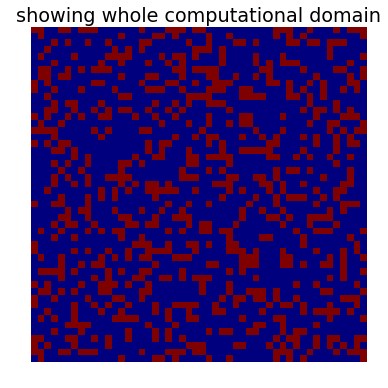

In [7]:
myfig,myaxis = plt.subplots(figsize=(6,6))
myaxis.axis('off')
plt.title('showing whole computational domain')
myaxis.imshow(c,interpolation="nearest");

In [8]:
q = c[1:-1,1:-1] # q is the interior of c
print(q)

[[1 0 0 ..., 0 0 0]
 [0 0 1 ..., 1 0 0]
 [0 1 0 ..., 0 0 0]
 ..., 
 [1 0 0 ..., 0 0 1]
 [0 1 0 ..., 1 0 1]
 [1 0 0 ..., 0 1 1]]


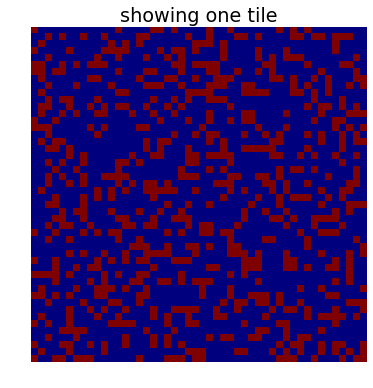

In [9]:
myfig,myaxis = plt.subplots(figsize=(6,6))
myaxis.axis('off')
plt.title('showing one tile')

myaxis.imshow(q,interpolation="nearest"); 

Below we demonstrate two ways to update the cells in Conway's Game of Life. 

In `slowstep` we examine the cells one at a time, count the neighbors and store the updated value of the cell.  Later we show `neighbors` and `faststep`, which use the numpy array syntax. That syntax is more compact but more obscure.  In most applications in this course, the array syntax is **much** faster and is essential.  But for the animation here, we deliberately slow down the computation so that the frames don't change too fast, so the slow way is acceptable too.  So the point here is to give a gentle introduction to using arrays in similar way to how we must use them to simulate PDEs quickly.

In [10]:
def slowstep(b):
    I, J = b.shape
    s = b.copy() # s will store the updated values of b
    for i in range(1,I-1):
        for j in range(1,J-1): # the n= statement is formatted to represent
            # the physical location of the adjacent cells
            n = +b[i-1,j-1] + b[i-1,j] + b[i-1,j+1] \
                +b[i  ,j-1] +            b[i,j+1]  \
                +b[i+1,j-1] + b[i+1,j] + b[i+1,j+1] 
            if b[i,j] == 1 and (n < 2 or n > 3):
                s[i,j] = 0 
            elif b[i,j] == 0 and n == 3:
                s[i,j] = 1
    b[:,:] = s # copy the updated values into b

Now for the fast way.

`neighbors` returns an array with a count of the number of neighbors that are alive.  This array programming style is used throughout this course. It is important to master this, and see how it is equivalent to `slowstep`. Note how 8 shifted arrays are sampled. Admittedly, a sketch of the relative domains of the 8 arrays could be helpful here. Maybe you can make such a sketch.  

Note the returned array is 2 rows and 2 columns smaller than the input array `b`. The input array is assumed to have the adjacent rows and columns copied to its edges. 

In [11]:
# the typography should hint at how the shift in the slices
# counts the neighboring cells that are "alive" (meaning == 1 )
def neighbors(b):
    return \
    b[:-2,:-2] +b[:-2,1:-1] +b[:-2,2:] + \
    b[1:-1,:-2]             +b[1:-1,2:]+ \
    b[2:,:-2]  +b[2:,1:-1]  +b[2:,2:]

In [12]:
print(c)

[[1 1 0 ..., 1 1 1]
 [0 1 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 0]
 ..., 
 [1 0 1 ..., 0 1 0]
 [1 1 0 ..., 1 1 1]
 [0 1 0 ..., 0 0 1]]


In [13]:
print(neighbors(c))

[[2 3 2 ..., 4 3 4]
 [2 3 1 ..., 1 1 1]
 [2 2 2 ..., 2 1 1]
 ..., 
 [3 3 2 ..., 2 3 2]
 [6 2 2 ..., 3 5 5]
 [4 3 2 ..., 3 3 4]]


In [14]:
# b has the perimeter cells, we only change the part not on the perimeter
def faststep(b): 
    n = neighbors(b) # n will be the array containing the count of alive neighbors 
    b[1:-1,1:-1] = np.where(np.logical_or( n==3 , np.logical_and( b[1:-1,1:-1] , n==2 ) ), 1, 0)
# see Appendix to help you wrap your head around this ^^^    

You may want to highlight this cell, then **Cell>Run All Above**.
Wait until all the cells above execute, then execute the cells below.

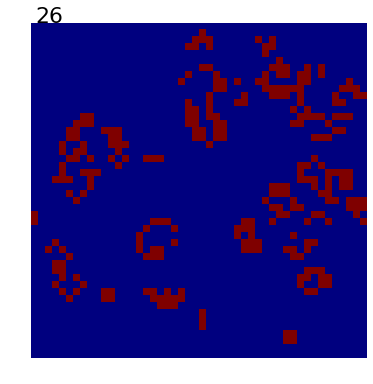

In [ ]:
# You may execute this cell repeatedly, to do nsteps more
nsteps = 40
step_type = 1
myfig,myaxis = plt.subplots(figsize=(6,6))
myaxis.axis('off')
count=0
while count < nsteps:
    if step_type == 1:
        faststep(c)
    elif step_type == 0:
        slowstep(c)
    else:
        print("not implemented yet")
    if enforce_periodic: periodic(c)
    
    myaxis.clear()
    myaxis.imshow( c[1:-1,1:-1], interpolation="nearest") 
    myaxis.text( .0, -0.6, '{0:d}'.format(count), fontsize=22)
    myaxis.axis("off")
    
#    Time.sleep(0.1) # show pix for 0.1 seconds
    clear_output(wait=True) # wait means do not really clear it until next display
    Time.sleep(0.4)
    display(myfig) 
    count+=1
plt.close()   

<hr>
# Student Tasks: 

Add two more options for `init_choice`

## 1.  initialize a standard option

Look again at [The online Game of Life](http://www.bitstorm.org/gameoflife/).  Note intialization options such as *Tumbler* and *10 Cell Row*.  Try to initialize one of those options in the above cells notebook.

## 2.  Initialize your name

At t=13s in [Does John Conway hate his Game of Life?](https://youtu.be/E8kUJL04ELA), we see the *Game of Life* initialized with a name. Do such an initialization for your name, or at least your two or three initials.


# Appendix

Need a reference?

A 24-page pdf document, emphasizing array slicing and indexing: http://www.engr.ucsb.edu/~shell/che210d/numpy.pdf

### a quick demo of some array syntax used in this notebook
(other than slicing or indexing)

In [16]:
z = np.array([1,0,0])

In [17]:
w = np.array([1,1,0])

In [18]:
z == 1

array([ True, False, False], dtype=bool)

In [19]:
z == True # 0 is interpreted as False

array([ True, False, False], dtype=bool)

In [20]:
np.logical_and(z,w)

array([ True, False, False], dtype=bool)

In [21]:
np.logical_or(z,w)

array([ True,  True, False], dtype=bool)

In [22]:
np.where( np.logical_or(z,w) , -9, 7 )

array([-9, -9,  7])